$\newcommand{\bbT}{\mathbb{T}}$
$\newcommand{\bbR}{\mathbb{R}}$
$\newcommand{\bbL}{\mathbb{L}}$
$\newcommand{\oc}{\overline{c}}$
$\newcommand{\ol}{\overline{l}}$

## Feature Reduction

Under the assumption that we have completed task $t_4$ we may assume that all the tables/dataframes that we are considering are of the form $E\subseteq \bbT\times \bbR^m \times \bbL^n$ then we may have that the cardinality of $F = \{ (r_1, \ldots, r_m, l_1, \ldots, l_n): \exists t \mbox{ s.t. } (t, r_1, \ldots, r_m, l_1, \ldots, l_n) \in E \}$ may be too large, for that reason we want to reduce the variety of possible events by implementing a function 
$fr:  \rightarrow \bbR^m \times \bbL^n \rightarrow \bbL^k$
which transforms each tuple for each $( r_1, \ldots, r_m, l_1, \ldots, l_n) \in E$ into a tuple $(l_1, \ldots, l_k)$
of labels in order that the cardinality of $F_{fr}=\{ fr(r_1, \ldots, r_m, l_1, \ldots, l_n): \exists t \mbox{ s.t. } (t, r_1, \ldots, r_m, l_1, \ldots, l_n) \in E \}$ satisfies $|F_{fr}| << |F|$.

let us notice that $fr$ may be composed of various functions that consider different part of the tuple $(r_1, \ldots, r_m, l_1, \ldots, l_n)$, we will make a concrete example using the calories example built at the previous step:

In [1]:
import nbimporter
from ETLBasics_t1 import calories_to_df
import dateutil as du
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
PATH = '../../../datasets/pmdata/'

In [2]:
calories_to_df(PATH, [1,2,3])
df = calories_to_df(PATH, [1,2,3])
df['pid'] = [x[0] for x in list(df.index)]
df['ts'] = [x[1] for x in list(df.index)]
df['tsh'] =  df['ts'].apply(lambda x: x.strftime('%Y-%m-%d_%H'))
df_agg = df.groupby(['pid', 'tsh']).agg({'calories':['mean', 'std']})
df_agg['c_mean'] = df_agg['calories']['mean']
df_agg['c_std'] = df_agg['calories']['std']
df_agg = df_agg.drop(['calories'], axis=1)
df_agg['ts'] = [x[1] for x in list(df_agg.index)]
df_agg['date'] = df_agg['ts'].apply(lambda x: du.parser.parse(x[0:-3]))
df_agg['hour'] =  df_agg['ts'].apply(lambda x: int(x[-2:])) 
df_agg['eight_part_day'] = df_agg['hour'].apply(lambda x: int(x/3)) 
df_agg['quarter_day'] = df_agg['hour'].apply(lambda x: int(x/6)) 
df_agg['half_day'] = df_agg['hour'].apply(lambda x: int(x/12)) 
df_agg['week_day'] = df_agg['date'].apply(lambda x: x.strftime('%A'))
df_agg['weekend']= df_agg['week_day'].apply(lambda x: True if x in ['Saturday', 'Sunday'] else False) 
df_agg = df_agg.drop(['date', 'ts'], axis=1)
df_agg

c_mean     c_std hour eight_part_day quarter_day  \
                                                                        
pid tsh                                                                 
1   2019-11-01_00  1.390000  0.000000    0              0           0   
    2019-11-01_01  1.397000  0.054222    1              0           0   
    2019-11-01_02  1.392333  0.018074    2              0           0   
    2019-11-01_03  1.399333  0.035217    3              1           0   
    2019-11-01_04  1.399333  0.035217    4              1           0   
...                     ...       ...  ...            ...         ...   
3   2020-03-31_19  2.070667  1.175683   19              6           3   
    2020-03-31_20  1.552000  0.541876   20              6           3   
    2020-03-31_21  1.340000  0.000000   21              7           3   
    2020-03-31_22  1.340000  0.000000   22              7           3   
    2020-03-31_23  1.340000  0.000000   23              7           3   

                  half_day week_day weekend  
                                             
pid tsh                                      
1   2019-11-01_00        0   Friday   False  
    2019-11-01_01        0   Friday   False  
    2019-11-01_02        0   Friday   False  
    2019-11-01_03        0   Friday   False  
    2019-11-01_04        0   Friday   False  
...                    ...      ...     ...  
3   2020-03-31_19        1  Tuesday   False  
    2020-03-31_20        1  Tuesday   False  
    2020-03-31_21        1  Tuesday   False  
    2020-03-31_22        1  Tuesday   False  
    2020-03-31_23        1  Tuesday   False  

[10944 rows x 8 columns]

How many pairs $(mean, standard\ deviation)$ pairs do we have:

In [3]:
mean_std_list =  [(x[0], x[1]) for x in  [list(x) for x in list(df_agg.to_numpy())]]
mean_std_set = set(mean_std_list)
len(mean_std_set)

7729

We can apply a k-means clustering in order to reduce  the numbers of $(mean, standard\ deviation)$ pairs.
In such a case we have to normalize the values because they represent two different measures:

In [4]:
mean_list = [x[0] for x in mean_std_list] 
min_mean, max_mean = min(mean_list), max(mean_list)
std_list = [x[1] for x in mean_std_list] 
min_std, max_std = min(std_list), max(std_list)
mean_range = max_mean - min_mean
std_range = max_std - min_std
min_mean, max_mean, mean_range, min_std, max_std, std_range

(1.16,
 15.409500000000001,
 14.249500000000001,
 0.0,
 7.800998043854772,
 7.800998043854772)

In [5]:
mean_range
norm_mean_std_list = [ ((x[0] - min_mean)/mean_range, (x[1] - min_std)/std_range) for x in  mean_std_list   ]

In [6]:
points = np.array(norm_mean_std_list)
points = np.array(mean_std_list)
points = np.array(list(set(mean_std_list)))
errors = []

In [16]:
ncl = 6
kmeans = KMeans(n_clusters=ncl, random_state=0).fit(points)
cluster_indexes = kmeans.predict(points)

In [17]:
cluster_centers =  kmeans.cluster_centers_

In [18]:
point_centers = [ cluster_centers[i] for i in cluster_indexes ]

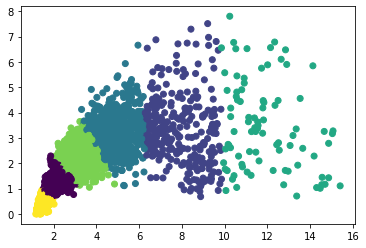

In [19]:
plt.scatter(
     [i[0] for i in points], 
     [i[1] for i in points],
    c =  list(cluster_indexes)) 
plt.show()

In [11]:
error = np.array([ (distance.euclidean(point_centers[i], points[i]))**2 for i in range(len(points))]).sum()/len(points) 
error

0.5020708661251145

In [12]:
errors.append((ncl, error))

In [13]:
errors = list(set(errors))
errors.sort(key= lambda x: x[0])

In [14]:
errors

[(5, 0.5020708661251145)]

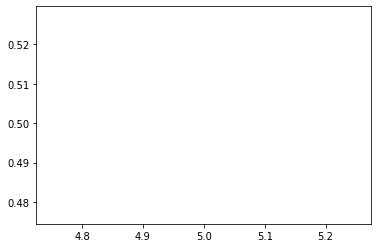

In [15]:
plt.plot([i[0] for i in errors], [i[1] for i in errors])

Let  us put everything together in a function

In [9]:
def calories_kmeans(df_cal, n_clusters=2,  normalized=False, ignore_cardinalities= False):
    df = df_cal.copy()
    df['pid'] = [x[0] for x in list(df.index)]
    df['ts'] = [x[1] for x in list(df.index)]
    df['tsh'] =  df['ts'].apply(lambda x: x.strftime('%Y-%m-%d %H:00:00'))
    df_agg = df.groupby(['pid', 'tsh']).agg({'calories':['mean', 'std']})
    df_agg['c_mean'] = df_agg['calories']['mean']
    df_agg['c_std'] = df_agg['calories']['std']
    df_agg = df_agg.drop(['calories'], axis=1)
    df_agg['ts'] = [x[1] for x in list(df_agg.index)]
    df_agg['date'] = df_agg['ts'].apply(lambda x: du.parser.parse(x[0:-3]))
    df_agg['hour'] =  df_agg['ts'].apply(lambda x: int(x[-2:])) 
    df_agg['eight_part_day'] = df_agg['hour'].apply(lambda x: int(x/3)) 
    df_agg['quarter_day'] = df_agg['hour'].apply(lambda x: int(x/6)) 
    df_agg['half_day'] = df_agg['hour'].apply(lambda x: int(x/12)) 
    df_agg['week_day'] = df_agg['date'].apply(lambda x: x.strftime('%A'))
    df_agg['weekend']= df_agg['week_day'].apply(lambda x: True if x in ['Saturday', 'Sunday'] else False) 
    df_agg = df_agg.drop(['date', 'ts'], axis=1)
    mean_std_list =  [(x[0], x[1]) for x in  [list(x) for x in list(df_agg.to_numpy())]]
    mean_std_set = set(mean_std_list)
    mean_list = [x[0] for x in mean_std_list] 
    min_mean, max_mean = min(mean_list), max(mean_list)
    std_list = [x[1] for x in mean_std_list] 
    min_std, max_std = min(std_list), max(std_list)
    mean_range = max_mean - min_mean
    std_range = max_std - min_std
    norm_mean_std_list = [ ((x[0] - min_mean)/mean_range, (x[1] - min_std)/std_range) for x in  mean_std_list   ]
    points = norm_mean_std_list if normalized else mean_std_list
    points = list(set(points)) if ignore_cardinalities else points
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
    cluster_indexes = kmeans.predict(points)
    df_agg['cluster_index'] = cluster_indexes
    cluster_centers =  kmeans.cluster_centers_
    point_centers = [ cluster_centers[i] for i in cluster_indexes ]
    df_agg['cluster_center'] = point_centers
    return df_agg

In [10]:
r  = calories_kmeans(calories_to_df(PATH, [1,2,3]))

In [11]:
r

c_mean     c_std hour eight_part_day quarter_day  \
                                                                              
pid tsh                                                                       
1   2019-11-01 00:00:00  1.390000  0.000000    0              0           0   
    2019-11-01 01:00:00  1.397000  0.054222    0              0           0   
    2019-11-01 02:00:00  1.392333  0.018074    0              0           0   
    2019-11-01 03:00:00  1.399333  0.035217    0              0           0   
    2019-11-01 04:00:00  1.399333  0.035217    0              0           0   
...                           ...       ...  ...            ...         ...   
3   2020-03-31 19:00:00  2.070667  1.175683    0              0           0   
    2020-03-31 20:00:00  1.552000  0.541876    0              0           0   
    2020-03-31 21:00:00  1.340000  0.000000    0              0           0   
    2020-03-31 22:00:00  1.340000  0.000000    0              0           0   
    2020-03-31 23:00:00  1.340000  0.000000    0              0           0   

                        half_day week_day weekend cluster_index  \
                                                                  
pid tsh                                                           
1   2019-11-01 00:00:00        0   Friday   False             0   
    2019-11-01 01:00:00        0   Friday   False             0   
    2019-11-01 02:00:00        0   Friday   False             0   
    2019-11-01 03:00:00        0   Friday   False             0   
    2019-11-01 04:00:00        0   Friday   False             0   
...                          ...      ...     ...           ...   
3   2020-03-31 19:00:00        0  Tuesday   False             0   
    2020-03-31 20:00:00        0  Tuesday   False             0   
    2020-03-31 21:00:00        0  Tuesday   False             0   
    2020-03-31 22:00:00        0  Tuesday   False             0   
    2020-03-31 23:00:00        0  Tuesday   False             0   

                                                   cluster_center  
                                                                   
pid tsh                                                            
1   2019-11-01 00:00:00  [1.6633969445044274, 0.5701456191355561]  
    2019-11-01 01:00:00  [1.6633969445044274, 0.5701456191355561]  
    2019-11-01 02:00:00  [1.6633969445044274, 0.5701456191355561]  
    2019-11-01 03:00:00  [1.6633969445044274, 0.5701456191355561]  
    2019-11-01 04:00:00  [1.6633969445044274, 0.5701456191355561]  
...                                                           ...  
3   2020-03-31 19:00:00  [1.6633969445044274, 0.5701456191355561]  
    2020-03-31 20:00:00  [1.6633969445044274, 0.5701456191355561]  
    2020-03-31 21:00:00  [1.6633969445044274, 0.5701456191355561]  
    2020-03-31 22:00:00  [1.6633969445044274, 0.5701456191355561]  
    2020-03-31 23:00:00  [1.6633969445044274, 0.5701456191355561]  

[10944 rows x 10 columns]

## Deal with Categorical Labels and the whole tuple

If it is the case that even after the reduction of real labels the value $|F_{fr}|$ is still 
too big then we can apply word2vec techniques  for assigning a dense vector $v_t \in \bbR^{n_E}$ to each tuple $t \in F_fr$
and then **collapse** similar tuples $t,t'$ into the same group $T$ if and only if $\cos\mbox{-}dist(v_{t}, v_{t'})> \epsilon$
for a given threshold $0 < \epsilon < 1$. Take into consideration that in such a case you have the following parameters to
ask the user:
- $\epsilon$;
- the size of the embedding vectors $n_E$;
- the fact that you will consider time-frame of fixed duration-size $D$ or fixed-cardinality size $C$;
- if fixed duration-size $D$ is chosen then the duration stride $S_D$ should be chosen 
  (e.g., we may consider a time-frame of $6$ hours with strides of half an hour);
- if we choose fixed-cardinality size $C$ is chosen then the step stride $C_D$ should be chosen, e.g., we may consider a time-frame of $5$ events, that is, range $radius=2$,  with strides of $2$ events;
- the use of either $skip\mbox{-}gram$ or $cbow$ method for computing the embeddings.

## Reference

To the best of my knowledge the first paper talking about $k$-means 
clustering is the following:

- MacQueen, James. "Some methods for classification and analysis of multivariate observations." In Proceedings of the fifth Berkeley symposium on mathematical statistics and probability, vol. 1, no. 14, pp. 281-297. 1967.

However, you will find  online a huge amount of resources/variation application of the method, including various strategies/measures, such as the so called ''elbow-method'', 
for determining automatically the best number of clusters.